In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency
from scipy.stats import chi2

df = pd.read_pickle('treino.pkl.gz')

In [2]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (20, 8)

In [3]:
print(len(df))
print(df['tem_med_emp'].isnull().value_counts().sum())
print(df['tem_pri_emp'].isnull().value_counts().sum())

# series consistentes

186523
186523
186523


In [4]:
# em que formato se encontram os dados de 'tem_med_emp' ?

df['tem_med_emp'].unique()

# percebe-se que todos possuem inteiros, seguidos de 'yrs' e 'mon', (anos, meses)
# não é possível fazer um único slice para separar anos e meses, posto que meses e anos podem ter um ou dois 
# dígitos

array(['0yrs 8mon', '1yrs 1mon', '0yrs 5mon', '0yrs 10mon', '0yrs 0mon',
       '1yrs 4mon', '1yrs 11mon', '0yrs 11mon', '2yrs 1mon', '2yrs 3mon',
       '0yrs 7mon', '0yrs 6mon', '3yrs 3mon', '4yrs 1mon', '2yrs 4mon',
       '1yrs 5mon', '1yrs 0mon', '2yrs 2mon', '2yrs 0mon', '1yrs 6mon',
       '1yrs 7mon', '1yrs 3mon', '0yrs 3mon', '1yrs 2mon', '3yrs 8mon',
       '0yrs 9mon', '0yrs 4mon', '2yrs 10mon', '3yrs 1mon', '1yrs 10mon',
       '4yrs 8mon', '1yrs 8mon', '3yrs 0mon', '2yrs 6mon', '2yrs 7mon',
       '7yrs 9mon', '1yrs 9mon', '0yrs 2mon', '8yrs 0mon', '3yrs 9mon',
       '3yrs 5mon', '2yrs 9mon', '5yrs 2mon', '2yrs 5mon', '3yrs 7mon',
       '3yrs 10mon', '3yrs 6mon', '14yrs 0mon', '7yrs 3mon', '3yrs 2mon',
       '2yrs 8mon', '7yrs 5mon', '0yrs 1mon', '5yrs 6mon', '6yrs 0mon',
       '4yrs 3mon', '7yrs 10mon', '5yrs 3mon', '6yrs 1mon', '4yrs 5mon',
       '5yrs 7mon', '5yrs 9mon', '6yrs 2mon', '4yrs 4mon', '6yrs 7mon',
       '4yrs 0mon', '10yrs 8mon', '4yrs 10mon', '4yrs 2m

In [5]:
df['tem_pri_emp'].unique()

array(['5yrs 5mon', '1yrs 1mon', '1yrs 4mon', '3yrs 1mon', '0yrs 0mon',
       '1yrs 11mon', '1yrs 3mon', '2yrs 1mon', '2yrs 3mon', '0yrs 7mon',
       '0yrs 6mon', '16yrs 11mon', '9yrs 5mon', '2yrs 7mon', '4yrs 2mon',
       '2yrs 6mon', '0yrs 10mon', '2yrs 0mon', '3yrs 0mon', '13yrs 4mon',
       '5yrs 10mon', '1yrs 9mon', '1yrs 0mon', '4yrs 8mon', '1yrs 7mon',
       '3yrs 8mon', '0yrs 3mon', '1yrs 6mon', '1yrs 5mon', '1yrs 10mon',
       '0yrs 9mon', '5yrs 6mon', '0yrs 11mon', '3yrs 2mon', '4yrs 4mon',
       '2yrs 10mon', '0yrs 8mon', '6yrs 3mon', '3yrs 6mon', '6yrs 4mon',
       '6yrs 9mon', '2yrs 2mon', '3yrs 5mon', '7yrs 0mon', '4yrs 3mon',
       '1yrs 2mon', '3yrs 4mon', '4yrs 10mon', '5yrs 4mon', '4yrs 11mon',
       '4yrs 0mon', '5yrs 3mon', '3yrs 9mon', '6yrs 2mon', '2yrs 11mon',
       '13yrs 10mon', '4yrs 1mon', '0yrs 4mon', '2yrs 4mon', '7yrs 9mon',
       '2yrs 5mon', '0yrs 2mon', '16yrs 0mon', '1yrs 8mon', '3yrs 11mon',
       '5yrs 1mon', '11yrs 4mon', '4yrs 6mon', '

In [6]:
# pretendo transformar os valores em meses apenas (1 ano = 12 meses)
def time_unit_unification(x):
    sub1 = x.split(' ')[0]
    sub2 = x.split(' ')[1]
    return (int(sub1.strip('yrs')) * 12) + int(sub2.strip('mon'))

df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

39.0


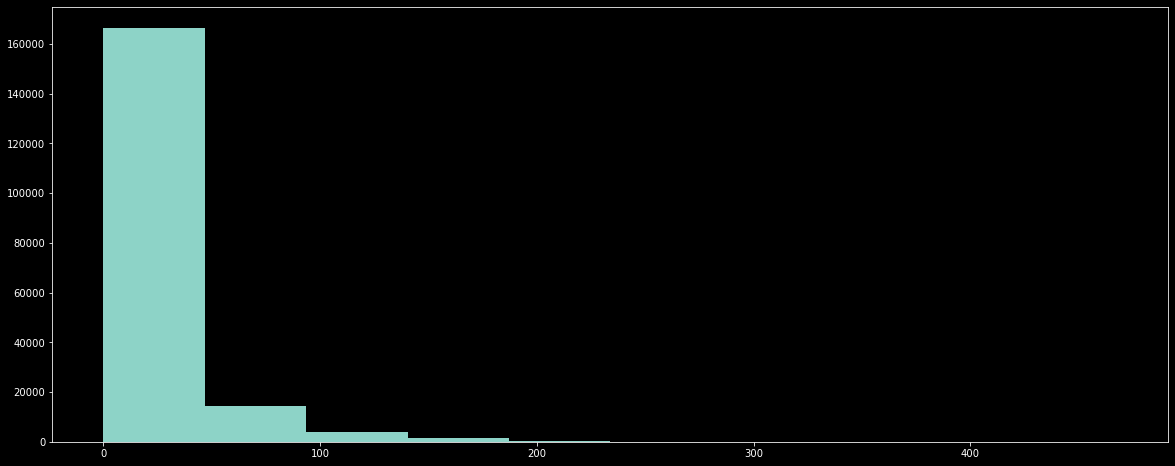

In [7]:
# categorização de 'tem_pri_emp'
print(df['tem_pri_emp'].max() / 12)
plt.hist(df['tem_pri_emp'])
plt.show()

# o range inicial é 0-39 anos
# a princípio, não eliminarei outliers

In [8]:
# durante o cálculo do threshold de percentis, percebo que há grande proporção de zeros
# nestes casos, suponho que se trate de alguém que nunca tomou empréstimos (desconsidero a possibilidade de
# o empréstimo ter sido tomado a menos de um mês)
print(round(len(df.loc[df['tem_pri_emp'] == 0]) / len(df) * 100, 2))
# mais o menos metade dos dados não possuem histórico de empréstimos (a análise dos scores corrobora esta
# informação)

# imagino que 'tem_med_emp' trará algo semelhante
print(round(len(df.loc[df['tem_med_emp'] == 0]) / len(df) * 100, 2))

51.15
51.25


In [9]:
# prosseguirei com a categorização, alocando zeros sob o um único label, e dividindo valores remanescentes
# em percentis

In [10]:
# 'tem_pri_emp'

# retornando à categorização

df_time_pri = df.loc[df['tem_pri_emp'] != 0]
df_no_time_pri = df.loc[df['tem_pri_emp'] == 0]

time_pri_thrshld1 = np.quantile(df_time_pri['tem_pri_emp'], 0.33)
time_pri_thrshld2 = np.quantile(df_time_pri['tem_pri_emp'], 0.66)

In [12]:
def categorize_time(x, threshold1, threshold2):
    if x == 0:
        return 'no_time'
    if x > 0 and x <= threshold1:
        return 'low'
    if x > threshold1 and x <= threshold2:
        return 'medium'
    if x > threshold2:
        return 'high'
    
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: categorize_time(x, time_pri_thrshld1,
                                                                         time_pri_thrshld2))

In [13]:
for i in df['tem_pri_emp'].unique():
    print(i, round(df.loc[df['tem_pri_emp'] == i, 'default'].value_counts(1).iloc[1] * 100, 2))
    
# percebe-se que 'no_time' possui a incidência de 'default' mais alta, 'low' e 'medium' estão próximos,
# e 'high' possui incidência consideravelmente mais baixa

high 18.06
low 20.62
medium 21.66
no_time 23.13


In [14]:
pd.crosstab(df['tem_pri_emp'], df['default'])

default,0,1
tem_pri_emp,,
high,25350,5587
low,25042,6506
medium,22431,6202
no_time,73338,22067


In [15]:
est, p, dof, exp = chi2_contingency(pd.crosstab(df['tem_pri_emp'], df['default']))

In [16]:
exp

array([[24242.49479689,  6694.50520311],
       [24721.27956338,  6826.72043662],
       [22437.06091474,  6195.93908526],
       [74760.16472499, 20644.83527501]])

In [17]:
est

378.0745835004401

In [18]:
chi2.ppf(df = dof, q = 0.9999999999)

49.542155758766434

In [19]:
# 'tem_med_emp'

df_time_med = df.loc[df['tem_med_emp'] != 0]
df_no_time_med = df.loc[df['tem_med_emp'] == 0]

time_med_thrshld1 = np.quantile(df_time_pri['tem_med_emp'], 0.33)
time_med_thrshld2 = np.quantile(df_time_pri['tem_med_emp'], 0.66)

df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: categorize_time(x, time_med_thrshld1,
                                                                            time_med_thrshld2))

for i in df['tem_med_emp'].unique():
    print(i, round(df.loc[df['tem_med_emp'] == i, 'default'].value_counts(1).iloc[1] * 100, 2))
    
    
# comportamento semelhante ao de 'tem_pri_emp', 'high' possui incidência mais baixa

low 20.23
medium 20.21
no_time 23.15
high 19.7


In [20]:
pd.crosstab(df['tem_med_emp'], df['default'])

default,0,1
tem_med_emp,,
high,24818,6090
low,24620,6245
medium,23259,5892
no_time,73464,22135


In [24]:
est, p, dof, exp = chi2_contingency(pd.crosstab(df['tem_med_emp'], df['default']))

In [25]:
exp

array([[24219.77015167,  6688.22984833],
       [24186.07498807,  6678.92501193],
       [22842.97009484,  6308.02990516],
       [74912.18476542, 20686.81523458]])

In [26]:
est

268.6535915892789

In [27]:
chi2.ppf(df = dof, q = 0.9999999999)

49.542155758766434